In [2]:
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')
print("GPUs Available: ", len(gpu))
tf.config.experimental.set_memory_growth(gpu[0], True)
import os
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import Input
from keras import applications
from keras import layers
from keras import models
from keras import utils
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.vgg16 import VGG16
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import cv2

GPUs Available:  1


In [3]:
inputTensor = Input(shape= (32,32,3))
up2d = layers.UpSampling2D((7,7))(inputTensor)
imgnet = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (224, 224, 3), input_tensor = up2d)
#imgnet.summary()

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
#x_train = x_train[-10000:]
#y_train = y_train[-10000:]

#x_test = x_test[:-9000]
#y_test = y_test[:-9000]
x_train.shape

(50000, 32, 32, 3)

In [4]:
y_train = to_categorical(y_train, dtype='int')
y_test = to_categorical(y_test, dtype='int')
y_test[9]

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

(50000, 10)

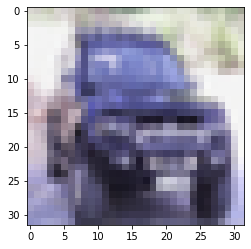

In [5]:
plt.imshow(x_test[9])
y_train.shape

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d_1 (UpSampling  (None, 224, 224, 3)      0         
 2D)                                                             
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 70ms/step


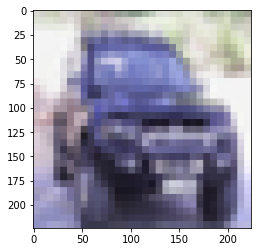

In [6]:
test = models.Sequential()
test.add(Input(shape=(32, 32, 3)))
test.add(layers.UpSampling2D(size= (7,7)))
test.summary()
img = x_test[9]
img = np.expand_dims(img, axis=0)
saida = test.predict(img)
saida.shape
saida = np.reshape(saida, (224,224,3))
saida = saida.astype(int)
plt.imshow(saida)

In [7]:
new = models.Sequential(imgnet.layers[:])
    
for layer in new.layers:
    layer.trainable = False
    
new.add(layers.Flatten())
new.add(layers.Dense(256, activation='relu'))
new.add(layers.Dense(64, activation='relu'))
new.add(layers.Dense(10, activation='softmax'))

new.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
new.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d (UpSampling2D  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                      

In [8]:
checkpoint_path = "./training/cp-{epoch:02d}-{val_accuracy:.5f}.hdf5"
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint = ModelCheckpoint(checkpoint_path, monitor = "val_accuracy", save_best_only = True, save_freq="epoch", mode = "max")
sstop = EarlyStopping(monitor = 'val_loss', patience = 1) 

In [9]:
TBcallback = tf.keras.callbacks.TensorBoard(log_dir = "logs/", histogram_freq = 1)
new.fit(x_train, y_train, epochs=15, validation_split=0.2, batch_size=128, callbacks=[checkpoint, TBcallback], shuffle = True)

Epoch 1/15
313/313 [==============================] - 135s 400ms/step - loss: 1.6143 - accuracy: 0.5808 - val_loss: 1.0381 - val_accuracy: 0.6593
Epoch 2/15
313/313 [==============================] - 123s 393ms/step - loss: 0.7601 - accuracy: 0.7408 - val_loss: 0.9710 - val_accuracy: 0.6902
Epoch 3/15
313/313 [==============================] - 123s 394ms/step - loss: 0.5484 - accuracy: 0.8103 - val_loss: 0.9801 - val_accuracy: 0.7064
Epoch 4/15
313/313 [==============================] - 123s 393ms/step - loss: 0.4066 - accuracy: 0.8592 - val_loss: 1.0513 - val_accuracy: 0.7010
Epoch 5/15
313/313 [==============================] - 123s 393ms/step - loss: 0.2991 - accuracy: 0.8968 - val_loss: 1.1537 - val_accuracy: 0.6979
Epoch 6/15
313/313 [==============================] - 123s 393ms/step - loss: 0.2263 - accuracy: 0.9224 - val_loss: 1.2839 - val_accuracy: 0.6973
Epoch 7/15
313/313 [==============================] - 123s 394ms/step - loss: 0.2096 - accuracy: 0.9259 - val_loss: 1.3478 -

In [10]:
new.evaluate(x_test, y_test)

313/313 [==============================] - 26s 82ms/step - loss: 2.0210 - accuracy: 0.7037


[2.0210366249084473, 0.7037000060081482]

In [11]:
new.trainable = True
new.compile(optimizer = optimizers.RMSprop(learning_rate = 0.000001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
checkpoint_path = "./training/cpFT-{epoch:02d}-{val_accuracy:.5f}.hdf5"
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint = ModelCheckpoint(checkpoint_path, monitor = "val_accuracy", save_best_only = True, save_freq="epoch", mode = "max")

new.fit(x_train, y_train, epochs=3, validation_split=0.2, batch_size=32, shuffle = True, callbacks=[checkpoint, TBcallback])

Epoch 1/3
1250/1250 [==============================] - 328s 260ms/step - loss: 0.0372 - accuracy: 0.9879 - val_loss: 2.0874 - val_accuracy: 0.7139
Epoch 2/3
1250/1250 [==============================] - 325s 260ms/step - loss: 0.0158 - accuracy: 0.9957 - val_loss: 2.2428 - val_accuracy: 0.7186
Epoch 3/3
1250/1250 [==============================] - 325s 260ms/step - loss: 0.0094 - accuracy: 0.9977 - val_loss: 2.3676 - val_accuracy: 0.7165


In [12]:
new.evaluate(x_test, y_test)
new.save('./models/CIFARup2d.h5')

313/313 [==============================] - 25s 80ms/step - loss: 2.3535 - accuracy: 0.7181


In [13]:
new.predict(x_test[9:10])

1/1 [==============================] - 0s 340ms/step


array([[1.5032043e-14, 1.0000000e+00, 1.8043182e-16, 1.4121242e-18,
        1.4458974e-12, 3.5740925e-13, 5.8560215e-13, 1.5270194e-21,
        5.5628624e-10, 2.2126120e-12]], dtype=float32)

In [14]:
new.layers